# Anomaly Detection


In [3]:
import pandas as pd
from pathlib import Path
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import *
import seaborn as sns
from pylab import rcParams
from sklearn.utils import shuffle
from pdb import set_trace
import matplotlib.pylab as plt
import sys
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, roc_auc_score, roc_curve
from sklearn.utils.multiclass import unique_labels

In [4]:
sys.path.append('/home/aggelos-i3/ForecastingLib/')
from tsutils import SequenceSpliter, huber_loss_mean

In [27]:
rcParams['figure.figsize'] = 20, 12
sns.set()

In [38]:
LOOKBACK = 10
LOOK_AHEAD = 1
ROLLING_WINDOW = 5
features=['voltage [V]', 
          'acceleration (actual) [m/(s*s)]', 
          'tractive effort (actual) [kN]',
          'track-earth voltage [V]',
          'speed (actual) [km/h]',
          'current [A]',
          'energy balance [kWh]',
          'way (actual) [km]']

In [39]:
df_new = pd.DataFrame()
s = 0.
pathlist = Path("/home/aggelos-i3/Downloads/simu Elbas/7h33NO").glob(
    '**/*.xls')
for path in pathlist:
    path_in_str = str(path)
    df = pd.read_csv(path_in_str, delimiter='\t', usecols=features)
    if df_new.empty:
        df_new = df[:1000]
    else:
        df_new += df[:1000]
    s += 1.

df_new /= s
df_new = df_new.rolling(window=ROLLING_WINDOW).mean().dropna()          

In [40]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = StandardScaler()
y_idx = df_new.columns.get_loc('voltage [V]')
scaler = scaler.fit(df_new)
df_scaled = scaler.transform(df_new)
spliter = SequenceSpliter(lookback=LOOKBACK, look_ahead=LOOK_AHEAD)

In [41]:
X, y = spliter.fit_transform(df_scaled)

In [42]:
X = np.delete(X, y_idx, 2)
# we need to forecast only the voltage
y = y[:, :, y_idx]

In [48]:
# now we will build our simple forecasting model
inputs = Input(shape=(X.shape[1:]))
q = LSTM(LOOKBACK)(inputs)
q = Dropout(0.8)(q)
x = Conv1D(256, kernel_size=32, padding='same')(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv1D(64, kernel_size=32, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv1D(64, kernel_size=32, padding='same')(x)
#x = BatchNormalization()(x)
#x = Activation('relu')(x)
x = concatenate([inputs, x])
x = GlobalMaxPooling1D()(x)
z = concatenate([x, q])
z = Dropout(0.8)(z)
outs = Dense(LOOK_AHEAD)(z)
model = tf.keras.Model(inputs, outs)
model.compile(loss=huber_loss_mean, optimizer='adam')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 10, 7)        0                                            
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 10, 256)      57600       input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 10, 256)      1024        conv1d_9[0][0]                   
__________________________________________________________________________________________________
activation_6 (Activation)       (None, 10, 256)      0           batch_normalization_6[0][0]      
__________________________________________________________________________________________________
conv1d_10 

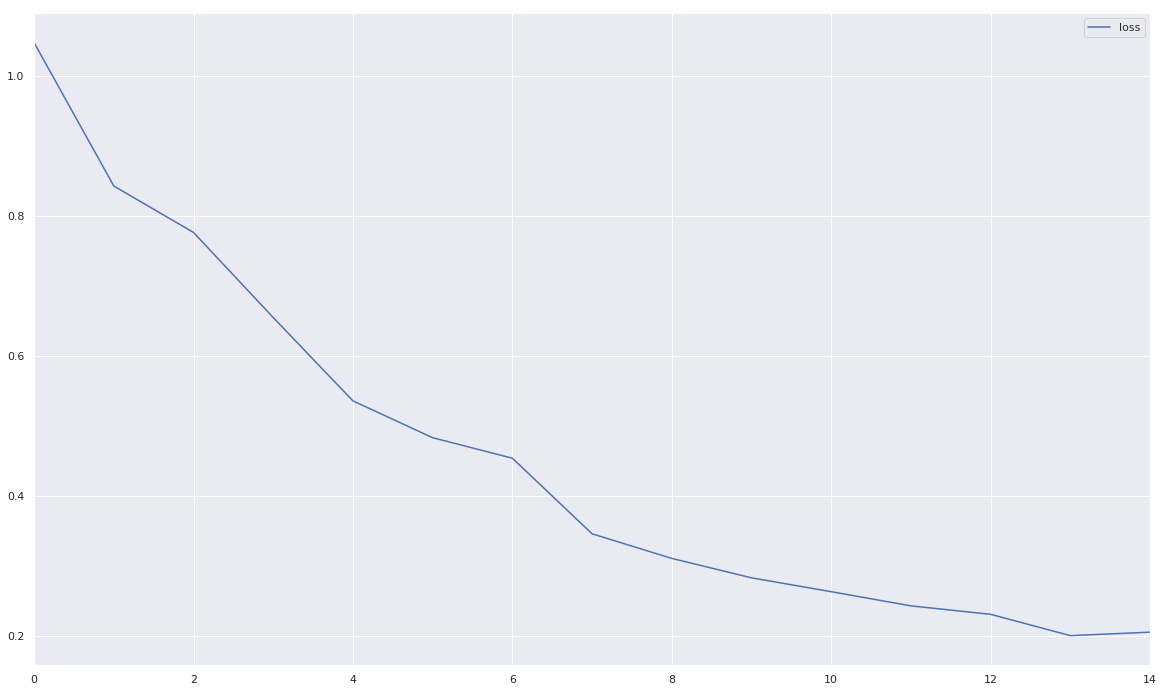

In [49]:
history = model.fit(X, y, epochs=15, verbose=0)
history = pd.DataFrame(history.history)
history.plot()

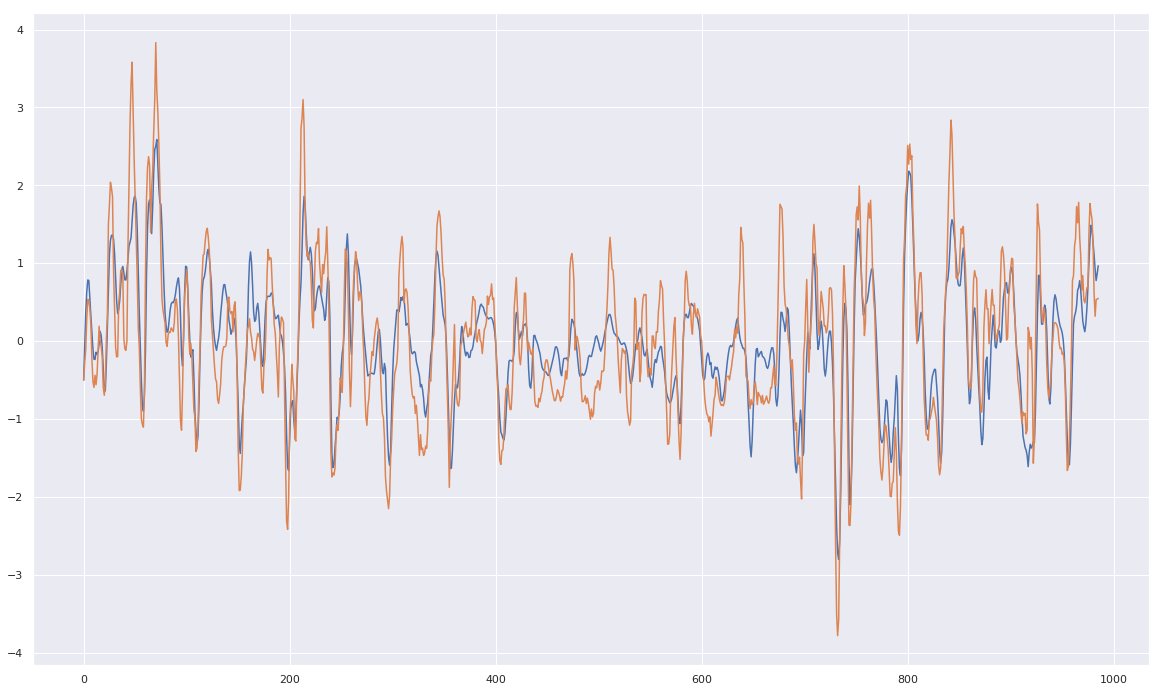

In [50]:
plt.plot(model.predict(X))
plt.plot(y)

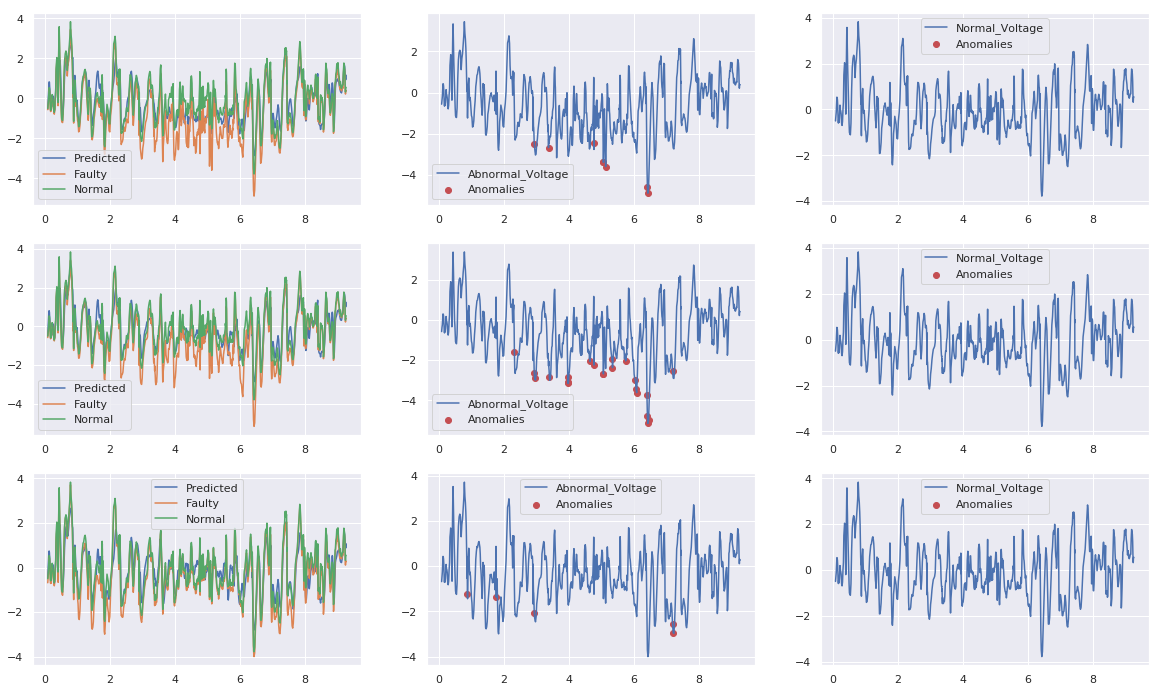

In [51]:
ERROR_TYPE = [1, 2, 3] #we can hav different labels for each error or the same label??
STD_MPL = 2
labels = []
train_set = []


PLOT_IDX = 0
rows = 3
i=1 # for plots
for DATASET_IDX in range(20):
    s=0.
    for error_type in ERROR_TYPE:
        df_faulty = pd.DataFrame()
        s = 0.
        pathlist = Path(f"/home/aggelos-i3/Downloads/simu Elbas/7h33D{error_type}").glob(
            '**/*.xls')
        for path in pathlist:
            path_in_str = str(path)
            df = pd.read_csv(path_in_str, delimiter='\t', usecols=features)
            if df_faulty.empty:
                df_faulty = df[:1000]
            else:
                df_faulty += df[:1000]
            s += 1.

        df_faulty /= s
        df_faulty = df_faulty.rolling(window=ROLLING_WINDOW).mean().dropna()
        y_idx = df_faulty.columns.get_loc('voltage [V]')
        df_scaled_faulty = scaler.transform(df_faulty)
        X_test, y_test = spliter.fit_transform(df_scaled_faulty)
        X_test = np.delete(X_test, y_idx, 2)
        y_test = y_test[:, :, y_idx]

        yhat = model.predict(X_test)
        
        yhat = yhat.reshape(yhat.shape[0]) 
        y_ = y.reshape(y.shape[0])
        y_test = y_test.reshape(y_test.shape[0]) 

        anomaly = y_test < yhat - STD_MPL * yhat.std()
        label = anomaly.astype(int) * 1
        labels.append(label)
        
        
        if DATASET_IDX==PLOT_IDX:
            plt.subplot(3,3,i)
            plt.plot(df_faulty['way (actual) [km]'][-len(yhat):], yhat, label='Predicted')
            plt.plot(df_faulty['way (actual) [km]'][-len(yhat):], y_test, label='Faulty')
            plt.plot(df_new['way (actual) [km]'][-len(yhat):], y, label='Normal')
            plt.legend(loc='best')
            
            plt.subplot(3,3,i+1)
            plt.plot(df_faulty['way (actual) [km]'][-len(yhat):], y_test, label='Abnormal_Voltage')
            plt.scatter(df_faulty['way (actual) [km]'][-len(yhat):],
                        np.where(anomaly, y_test, None),
                        c='r',
                        label='Anomalies')
            plt.legend(loc='best')

            anomaly = y_ < yhat - STD_MPL * yhat.std()
            plt.subplot(3,3,i+2)
            plt.plot(df_faulty['way (actual) [km]'][-len(yhat):], y_, label='Normal_Voltage')
            plt.scatter(df_new['way (actual) [km]'][-len(yhat):],
                        np.where(anomaly, y_, None),
                        c='r',
                        label='Anomalies')
            plt.legend(loc='best')


     
            
            i += 3
            
            
            
        train_set.append(X_test)
        
        

In [15]:
#dataset preprocessing ofr classification training
from sklearn.model_selection import train_test_split
labels = np.array(labels).reshape(-1,1)
train_set = np.array(train_set)
train_set = train_set.reshape(train_set.shape[0] * train_set.shape[1], train_set.shape[2], train_set.shape[3])
idx = np.random.permutation(len(train_set))
X,Y = train_set[idx], labels[idx]
train_X, test_X, train_y, test_y = train_test_split(X, Y)


In [16]:
# now we will build our simple forecasting model
inputs = Input(shape=(X.shape[1:]))
q = LSTM(LOOKBACK)(inputs)
q = Dropout(0.8)(q)
x = Conv1D(256, kernel_size=32, padding='same')(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv1D(32, kernel_size=32, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv1D(16, kernel_size=32, padding='same')(x)
#x = BatchNormalization()(x)
#x = Activation('relu')(x)
x = concatenate([inputs, x])
x = GlobalMaxPooling1D()(x)
z = concatenate([x, q])
z = Dropout(0.8)(z)
outs = Dense(2, activation='softmax')(z)
tf_model = tf.keras.Model(inputs, outs)
tf_model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
tf_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 100, 7)       0                                            
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 100, 256)     57600       input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 100, 256)     1024        conv1d_3[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 100, 256)     0           batch_normalization_2[0][0]      
__________________________________________________________________________________________________
conv1d_4 (

In [17]:
#undersampling of majority class
from imblearn.under_sampling import RandomUnderSampler # doctest: +NORMALIZE_WHITESPACE
rus = RandomUnderSampler()
x_ = train_X.reshape(train_X.shape[0], train_X.shape[1] * train_X.shape[2])
x_res, y_res = rus.fit_resample(x_,train_y)
x_res = x_res.reshape(x_res.shape[0], LOOKBACK, train_X.shape[2])


#sk_model.fit(x_res, y_res)
history = tf_model.fit(x_res, y_res, validation_split=0.3, epochs =40)

Train on 310 samples, validate on 134 samples
Epoch 1/40
310/310 [==============================] - 2s 6ms/step - loss: 0.9408 - acc: 0.6548 - val_loss: 0.3385 - val_acc: 0.7910
Epoch 2/40
310/310 [==============================] - 1s 3ms/step - loss: 0.6151 - acc: 0.7645 - val_loss: 0.3480 - val_acc: 0.7313
Epoch 3/40
310/310 [==============================] - 1s 3ms/step - loss: 0.4075 - acc: 0.8548 - val_loss: 0.4607 - val_acc: 0.7313
Epoch 4/40
310/310 [==============================] - 1s 3ms/step - loss: 0.4168 - acc: 0.8516 - val_loss: 0.1845 - val_acc: 1.0000
Epoch 5/40
310/310 [==============================] - 1s 3ms/step - loss: 0.3675 - acc: 0.8516 - val_loss: 0.1519 - val_acc: 1.0000
Epoch 6/40
310/310 [==============================] - 1s 3ms/step - loss: 0.3267 - acc: 0.8742 - val_loss: 0.2711 - val_acc: 0.9403
Epoch 7/40
310/310 [==============================] - 1s 3ms/step - loss: 0.2629 - acc: 0.9161 - val_loss: 0.1644 - val_acc: 0.9403
Epoch 8/40
310/310 [==========

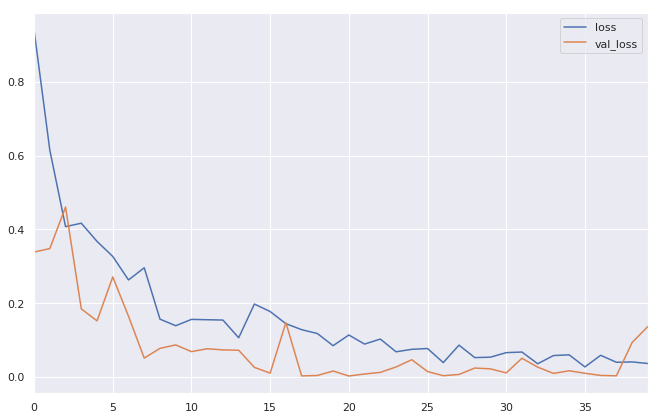

In [18]:
history = pd.DataFrame(history.history)
history[['loss', 'val_loss']].plot()

In [19]:
predictions = np.argmax(tf_model.predict(test_X), axis=1)


In [20]:
print(f"Accuracy: {accuracy_score(test_y, predictions)*100}%")
print(f"Recall: {recall_score(test_y, predictions)*100}%")
print(f"Precision: {precision_score(test_y, predictions)*100}%")
print(f"Accuracy: {accuracy_score(test_y, predictions)*100}%")
print(f"Recall: {recall_score(test_y, predictions)*100}%")
print(f"ROC: {roc_auc_score(test_y, predictions)}")

Accuracy: 98.6532251713003%
Recall: 91.46341463414635%
Precision: 31.380753138075313%
Accuracy: 98.6532251713003%
Recall: 91.46341463414635%
ROC: 0.950816874993958


In [21]:
def plot_confusion_matrix(y_true,
                          y_pred,
                          classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        # ... and label them with the respective list entries
        xticklabels=classes,
        yticklabels=classes,
        title=title,
        ylabel='True label',
        xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(),
             rotation=45,
             ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j,
                    i,
                    format(cm[i, j], fmt),
                    ha="center",
                    va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [22]:
class_names = np.array(['Normal', 'D1 Error', 'D2 error', 'D3 error'])


In [23]:
kf = KFold(5)
preds = []
true = []
for train_idx, test_idx in kf.split(x_res, y_res):
    #print("TRAIN:", train_idx, "TEST:", test_idx)
    X_train, X_test = x_res[train_idx], x_res[test_idx]
    y_train, y_test = y_res[train_idx], y_res[test_idx]
    tf_model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam')
    tf_model.fit(X_train, y_train, epochs=30, verbose=2)
    y_hat = tf_model.predict(X_test)
    preds.append(np.argmax(y_hat, axis=1))
    true.append(np.array(y_test).reshape(-1,)) 


#preds = preds.reshape(-1,1)

Epoch 1/30
 - 2s - loss: 0.0994
Epoch 2/30
 - 1s - loss: 0.0555
Epoch 3/30
 - 1s - loss: 0.0764
Epoch 4/30
 - 1s - loss: 0.0493
Epoch 5/30
 - 1s - loss: 0.0273
Epoch 6/30
 - 1s - loss: 0.0422
Epoch 7/30
 - 1s - loss: 0.0676
Epoch 8/30
 - 1s - loss: 0.0611
Epoch 9/30
 - 1s - loss: 0.0751
Epoch 10/30
 - 1s - loss: 0.0718
Epoch 11/30
 - 1s - loss: 0.0419
Epoch 12/30
 - 1s - loss: 0.0241
Epoch 13/30
 - 1s - loss: 0.0286
Epoch 14/30
 - 1s - loss: 0.0369
Epoch 15/30
 - 1s - loss: 0.0492
Epoch 16/30
 - 1s - loss: 0.0163
Epoch 17/30
 - 1s - loss: 0.0195
Epoch 18/30
 - 1s - loss: 0.0695
Epoch 19/30
 - 1s - loss: 0.0670
Epoch 20/30
 - 1s - loss: 0.0310
Epoch 21/30
 - 1s - loss: 0.0327
Epoch 22/30
 - 1s - loss: 0.0419
Epoch 23/30
 - 1s - loss: 0.0326
Epoch 24/30
 - 1s - loss: 0.0859
Epoch 25/30
 - 1s - loss: 0.0366
Epoch 26/30
 - 1s - loss: 0.0400
Epoch 27/30
 - 1s - loss: 0.0293
Epoch 28/30
 - 1s - loss: 0.0116
Epoch 29/30
 - 1s - loss: 0.0307
Epoch 30/30
 - 1s - loss: 0.0307
Epoch 1/30
 - 2s - 

KeyboardInterrupt: 

In [ ]:
true_ = np.concatenate(true, axis=0)

preds_ = np.concatenate(preds, axis=0)

plot_confusion_matrix(true_,
                      preds_,
                      classes=class_names,
                      normalize=True,
                      title='Normalized confusion matrix')

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(true_, preds_)
print(report)

In [ ]:
#report on full sampled data
kf = KFold(5)
preds = []
true = []
for train_idx, test_idx in kf.split(X, Y):
    #print("TRAIN:", train_idx, "TEST:", test_idx)
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = Y[train_idx], Y[test_idx]
    #tf_model.compile(loss='sparse_categorical_crossentropy', optimizer='RMSProp')
    #tf_model.fit(X_train, y_train, epochs=50, verbose=2)
    y_hat = tf_model.predict(X_test)
    preds.append(np.argmax(y_hat, axis=1))
    true.append(np.array(y_test).reshape(-1,)) 


In [ ]:
true_ = np.concatenate(true, axis=0)

preds_ = np.concatenate(preds, axis=0)

plot_confusion_matrix(true_,
                      preds_,
                      classes=class_names,
                      normalize=True,
                      title='Normalized confusion matrix')

In [ ]:
report = classification_report(true_, preds_)
print(report)

In [ ]:
tf.keras.models.save_model(tf_model, './models/anomaly_clfr.h5')
from sklearn.externals import joblib
scaler_filename = "./models/scaler.save"
joblib.dump(scaler, scaler_filename) 

In [ ]:
clf = tf.keras.models.load_model('./models/anomaly_clfr.h5')